In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pathlib import Path

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Konfigurasi Tampilan
%matplotlib inline
sns.set_style('whitegrid')

current_dir = Path(os.getcwd()) 
PROJECT_DIR = current_dir.parents[2]

# Lokasi Data & MLflow
INPUT_FILE = PROJECT_DIR / 'data' / 'processed' / 'features.csv'
MLRUNS_DIR = PROJECT_DIR / 'mlruns' 

print(f"📂 Posisi Notebook: {current_dir}")
print(f"📂 Project Root   : {PROJECT_DIR}")
print(f"📂 MLflow Path    : {MLRUNS_DIR}")
print(f"📄 Data File      : {INPUT_FILE}")

# --- 2. SETUP MLFLOW ---
if not MLRUNS_DIR.exists():
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR.as_posix()}")
mlflow.set_experiment("Roodio_Mood_RF_Experiment")

# --- 3. LOAD DATA ---
if not INPUT_FILE.exists():
    print(f"\n[ERROR] File tidak ditemukan!")
    print(f"Sistem mencari di: {INPUT_FILE}")
    print("Pastikan notebook ini berada di folder 'src/models'.")
    raise FileNotFoundError("File features.csv hilang!")

df = pd.read_csv(INPUT_FILE)
X = df.drop('label', axis=1)
y = df['label']

# Encode Label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"✅ Label Mapping: {label_mapping}")

# Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("✅ Setup Selesai. Siap Training.")

📂 Posisi Notebook: c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\src\models\audioModel
📂 Project Root   : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning
📂 MLflow Path    : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\mlruns
📄 Data File      : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\data\processed\features.csv
✅ Label Mapping: {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
✅ Setup Selesai. Siap Training.


🚀 Sedang Melatih Random Forest (Tunggu sebentar)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Training Selesai!
🏆 Parameter Terbaik : {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
📊 Akurasi Final     : 0.8993
⚖️ F1-Score (Macro)  : 0.8984


2026/01/22 13:56:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


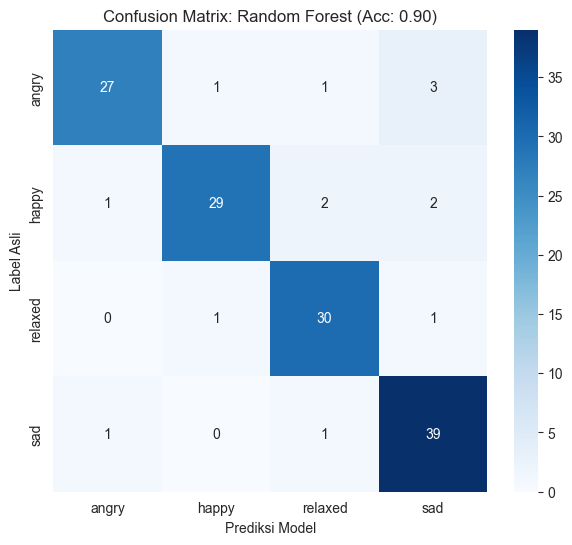

💾 Model, metrik lengkap, report.txt, dan gambar CM tersimpan di MLflow.


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score # <--- Import Tambahan

# --- 1. DEFINISI MODEL & PIPELINE ---
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# --- 2. GRID SEARCH PARAMETER ---
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],      
    'classifier__max_depth': [None, 10, 20],         
    'classifier__min_samples_split': [2, 5]          
}

# --- 3. EKSEKUSI TRAINING (DENGAN MLFLOW) ---
run_name = "RF_Tuning_Notebook"

with mlflow.start_run(run_name=run_name):
    print("🚀 Sedang Melatih Random Forest (Tunggu sebentar)...")
    
    # Grid Search
    grid = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # --- 4. EVALUASI ---
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_model.predict(X_test)
    
    # Hitung Metrik Utama
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')       # <--- BARU
    test_prec = precision_score(y_test, y_pred, average='macro') # <--- BARU
    test_recall = recall_score(y_test, y_pred, average='macro')  # <--- BARU
    
    print(f"\n✅ Training Selesai!")
    print(f"🏆 Parameter Terbaik : {best_params}")
    print(f"📊 Akurasi Final     : {test_acc:.4f}")
    print(f"⚖️ F1-Score (Macro)  : {test_f1:.4f}") # Print biar kelihatan di layar
    
    # --- 5. LOGGING KE MLFLOW (LENGKAP) ---
    # A. Log Parameter
    clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}
    mlflow.log_params(clean_params)
    
    # B. Log Metrik (Sekarang lebih banyak)
    metrics = {
        "accuracy": test_acc,
        "f1_macro": test_f1,
        "precision_macro": test_prec,
        "recall_macro": test_recall
    }
    mlflow.log_metrics(metrics) # <--- Log sekaligus
    
    # C. Log Classification Report sebagai File Teks (Artifact)
    # Ini trik pro: simpan laporan lengkap jadi file txt biar bisa dibuka di MLflow UI
    report_text = classification_report(y_test, y_pred, target_names=le.classes_)
    with open("classification_report.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_report.txt")
    
    # Hapus file lokal setelah upload agar bersih
    if os.path.exists("classification_report.txt"):
        os.remove("classification_report.txt")

    # D. Log Model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        signature=signature,
        input_example=X_train.iloc[:1]
    )
    
    # --- 6. VISUALISASI CONFUSION MATRIX ---
    plt.figure(figsize=(7,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: Random Forest (Acc: {test_acc:.2f})')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    
    # Simpan gambar CM ke MLflow juga
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()
    
    # Hapus file gambar lokal
    if os.path.exists("confusion_matrix.png"):
        os.remove("confusion_matrix.png")
        
    print("💾 Model, metrik lengkap, report.txt, dan gambar CM tersimpan di MLflow.")

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# --- EVALUASI MENDALAM ---
print("\n" + "="*40)
print("📊 LAPORAN EVALUASI MODEL")
print("="*40)

# 1. Classification Report (Mencakup Precision, Recall, F1)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 2. Metrik Global Spesifik
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_prec = precision_score(y_test, y_pred, average='macro')

print("-" * 40)
print(f"🏆 Macro F1-Score : {macro_f1:.4f} (Keseimbangan performa antar kelas)")
print(f"🎯 Macro Precision: {macro_prec:.4f} (Tingkat kepercayaan prediksi)")
print("-" * 40)

# 3. Analisis Kesalahan (Confusion Matrix Interpretation)
cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm, 0) 
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
true_label_err = le.classes_[max_error_idx[0]]
pred_label_err = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"⚠️ KESALAHAN TERBESAR MODEL:")
print(f"Model paling sering salah mengira '{true_label_err}' sebagai '{pred_label_err}'")
print(f"Jumlah kejadian: {count_err} kali.")
print("Analisis: Kemungkinan fitur audio kedua mood ini memiliki kemiripan (High Arousal/Low Valence).")


📊 LAPORAN EVALUASI MODEL
              precision    recall  f1-score   support

       angry       0.93      0.84      0.89        32
       happy       0.94      0.85      0.89        34
     relaxed       0.88      0.94      0.91        32
         sad       0.87      0.95      0.91        41

    accuracy                           0.90       139
   macro avg       0.90      0.90      0.90       139
weighted avg       0.90      0.90      0.90       139

----------------------------------------
🏆 Macro F1-Score : 0.8984 (Keseimbangan performa antar kelas)
🎯 Macro Precision: 0.9039 (Tingkat kepercayaan prediksi)
----------------------------------------
⚠️ KESALAHAN TERBESAR MODEL:
Model paling sering salah mengira 'angry' sebagai 'sad'
Jumlah kejadian: 3 kali.
Analisis: Kemungkinan fitur audio kedua mood ini memiliki kemiripan (High Arousal/Low Valence).
